In [1]:
from copy import deepcopy
from pathlib import Path
from pprint import pprint 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.width", 1000)

In [ ]:
from joblib import Memory
from shutil import rmtree

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    SelectKBest,
    VarianceThreshold,
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV, 
    StratifiedKFold,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.pipeline import Pipeline

from sksurv.util import Surv
from sksurv.linear_model import CoxnetSurvivalAnalysis

from lib.survival_scoring import fit_and_score_features
from lib.plotting import plot_kaplan_meier

set_config(display="text")  # displays text representation of estimators

In [3]:
import warnings
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning

warnings.simplefilter("ignore", UserWarning) # e.g. suppress wanrings such as UserWarning: all coefficients are zero, consider decreasing alpha.
warnings.simplefilter("ignore", FitFailedWarning)
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# load data

In [4]:
data_dir_proc = 'data/processed'

In [5]:
survival = pd.read_csv(Path(data_dir_proc) / 'survival.tsv', sep='\t', index_col=0)
print(survival.head())
print(survival.shape)

                     _PATIENT  OS  OS.time  DSS  DSS.time  DFI  DFI.time  PFI  PFI.time  Redaction
TCGA-69-7978-01  TCGA-69-7978   0    134.0  0.0     134.0  NaN       NaN    0     134.0        NaN
TCGA-62-8399-01  TCGA-62-8399   0   2696.0  0.0    2696.0  0.0    2696.0    0    2696.0        NaN
TCGA-78-7539-01  TCGA-78-7539   0    791.0  0.0     791.0  1.0     688.0    1     688.0        NaN
TCGA-73-4658-01  TCGA-73-4658   1   1600.0  0.0    1600.0  0.0    1600.0    0    1600.0        NaN
TCGA-44-6775-01  TCGA-44-6775   0    705.0  0.0     705.0  1.0     684.0    1     684.0        NaN
(506, 10)


In [6]:
clinical_cat = pd.read_csv(Path(data_dir_proc) / 'clinical_cat.tsv', sep='\t', index_col=0)
clinical_num = pd.read_csv(Path(data_dir_proc) / 'clinical_num.tsv', sep='\t', index_col=0)
clinical = clinical_cat.merge(clinical_num, how='inner', left_index=True, right_index=True)
print(clinical.head())
print(clinical.shape)

                 gender icd_o_3_histology icd_o_3_site other_dx pathologic_M  ... stopped_smoking_year tobacco_smoking_history year_of_initial_pathologic_diagnosis year_of_tobacco_smoking_onset tumour_volume
TCGA-69-7978-01    MALE            8255/3        C34.1       No          NaN  ...                  NaN     2_former_smoker<15y                               2011.0                           NaN           NaN
TCGA-62-8399-01    MALE            8255/3        C34.1       No           M0  ...                  NaN          4_never_smoked                               2006.0                           NaN           NaN
TCGA-78-7539-01  FEMALE            8255/3        C34.1       No           M0  ...               1981.0    3_former_smoker>=15y                               2011.0                        1953.0         0.504
TCGA-73-4658-01  FEMALE            8140/3        C34.3      Yes           M0  ...                  NaN    3_former_smoker>=15y                               2004.0     

In [7]:
expression = pd.read_csv(Path(data_dir_proc) / 'expression.tsv', sep='\t', index_col=0)
print(expression.head())
print(expression.shape)

                 ARHGEF10L    HIF3A   RNF17    RNF10    RNF11  ...     PTRF   BCL6B    GSTK1    SELP     SELS
TCGA-69-7978-01     9.9898   4.2598  0.4181  10.3657  11.1718  ...  12.7565  8.2668  11.2400  6.1209   9.8977
TCGA-62-8399-01    10.4257  11.6239  0.0000  11.5489  11.0200  ...  12.2100  8.5437  10.3491  8.6398   9.7315
TCGA-78-7539-01     9.6264   9.1362  1.1231  11.6692  10.4679  ...  10.6498  6.1814  11.1659  6.0970  10.3540
TCGA-73-4658-01     9.2078   5.0288  0.0000  11.6209  11.3414  ...  13.0036  8.9786  10.6777  8.4187  10.3142
TCGA-44-6775-01    10.0039   4.0573  1.0069  11.1721  11.0969  ...  12.7727  7.5911  10.3340  7.3311  10.0039

[5 rows x 20530 columns]
(506, 20530)


In [8]:
event_col = 'OS'
time_col = 'OS.time'
clinical_cat_cols = clinical.select_dtypes(include=['object', 'category', 'bool']).columns.to_list()
clinical_num_cols = clinical.select_dtypes(include=np.number).columns.to_list()
expression_cols = expression.columns
# expression_cols = expression.columns[:500].to_series()

In [9]:
y = Surv.from_dataframe(event=event_col, time=time_col, data=survival)
print(y.shape)
print(pd.DataFrame.from_records(y).head())
print(f'overall censoring rate: {(~y[event_col]).mean():.3}')

(506,)
      OS  OS.time
0  False    134.0
1  False   2696.0
2  False    791.0
3   True   1600.0
4  False    705.0
overall censoring rate: 0.638


In [10]:
X = clinical.loc[:, clinical_cat_cols + clinical_num_cols]\
    .merge(expression.loc[:, expression_cols], how='inner', left_index=True, right_index=True)
print(X.shape)
print(X.head())

(506, 20551)
                 gender icd_o_3_histology icd_o_3_site other_dx pathologic_M  ...     PTRF   BCL6B    GSTK1    SELP     SELS
TCGA-69-7978-01    MALE            8255/3        C34.1       No          NaN  ...  12.7565  8.2668  11.2400  6.1209   9.8977
TCGA-62-8399-01    MALE            8255/3        C34.1       No           M0  ...  12.2100  8.5437  10.3491  8.6398   9.7315
TCGA-78-7539-01  FEMALE            8255/3        C34.1       No           M0  ...  10.6498  6.1814  11.1659  6.0970  10.3540
TCGA-73-4658-01  FEMALE            8140/3        C34.3      Yes           M0  ...  13.0036  8.9786  10.6777  8.4187  10.3142
TCGA-44-6775-01  FEMALE            8140/3        C34.1       No          NaN  ...  12.7727  7.5911  10.3340  7.3311  10.0039

[5 rows x 20551 columns]


# pipeline

In [11]:
cachedir = "./.cache"
memory = Memory(location=cachedir, verbose=0)

clinical_cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encode', OneHotEncoder(drop='if_binary', sparse_output=False)),
    ('varthresh', VarianceThreshold(threshold=0.01)),
    ('select', SelectKBest(fit_and_score_features, k=5))
])

clinical_num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median', add_indicator=True)),
    ('varthresh', VarianceThreshold(threshold=1e-5)),
    ('scale', StandardScaler()),
    ('select', SelectKBest(fit_and_score_features, k=5))
])

expression_pipe = Pipeline([
    ('varthresh', VarianceThreshold(threshold=1e-5)),
    ('scale', StandardScaler()),
    ('select', PCA(svd_solver="randomized", random_state=42)),
])

preprocess_pipe = ColumnTransformer([
    ('clinical_cat', clinical_cat_pipe, clinical_cat_cols),
    ('clinical_num', clinical_num_pipe, clinical_num_cols),
    ('expression', expression_pipe, expression_cols),
])

coxnet_pipe = Pipeline([
    ('preprocess', preprocess_pipe),
    ('coxnet', CoxnetSurvivalAnalysis(max_iter=10000))
], memory=memory)

# params

alpha | l1_ratio | model
----- | -------- | ---
`0`     |          | ordinary regression (OLS?)
`>0`    | 0        | ridge
`>0`    | 1        | lasso

In [12]:
# make l1_ratios list and check bounds 
n_l1_ratios = 3
l1_ratios = np.linspace(0.1, 0.9, n_l1_ratios) # 0=Ridge, 1=Lasso
print(len(l1_ratios))
print(min(l1_ratios))
print(max(l1_ratios))

3
0.1
0.9


In [13]:
# use CoxnetSurvivalAnalysis to get an idea of approripate alphas
if True:
    alphas = np.array([])
    for l1_ratio in [min(l1_ratios), max(l1_ratios)]:
        print(f'l1_ratio: {l1_ratio}')
        temp_pipeline = Pipeline([
            ('preprocess', preprocess_pipe),
            ("coxnet", CoxnetSurvivalAnalysis(
                n_alphas=2,
                l1_ratio=l1_ratio, 
                alpha_min_ratio=0.01,
                tol=1e-3,
                max_iter=1,
            ))
        ])
        temp_pipeline.fit(X, y)
        alphas = np.append(alphas, temp_pipeline.named_steps["coxnet"].alphas_)
        alphas = np.array([alphas.min(), alphas.max()])
    min_alpha = np.min(alphas)
    max_alpha = np.max(alphas)
else:
    min_alpha = 0.0014189159585021821
    max_alpha = 1.277024362651964
print(f'min_alpha = {min_alpha}')
print(f'max_alpha = {max_alpha}')


l1_ratio: 0.1
l1_ratio: 0.9
min_alpha = 0.04138693911371897
max_alpha = 37.24824520234707


In [14]:
# make alphas list and check bounds 
n_alphas = 10
alphas = [float(x) for x in np.logspace(np.log(min_alpha), np.log(max_alpha), n_alphas, base=np.exp(1))]
# alphas = [float(x) for x in np.logspace(-3, 0.2, n_alphas)]
print(len(alphas))
print(min(alphas))
print(max(alphas))
alphas = [[x] for x in alphas] # the alphas parameter expects a list

10
0.04138693911371898
37.248245202347064


In [15]:
params = {
    "preprocess__expression__select__n_components": [10, 25, 50, 75, 100],
    "preprocess__clinical_cat__select__k": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "preprocess__clinical_num__select__k": [1, 2, 3, 4, 5],
    "coxnet__l1_ratio": [0.9],
    # "coxnet__l1_ratio": l1_ratios,
    "coxnet__alphas": alphas,  
}

In [16]:
# params = {
#     "preprocess__expression__select__n_components": [50],
#     "preprocess__clinical_cat__select__k": [3],
#     "preprocess__clinical_num__select__k": [1],
#     "coxnet__l1_ratio": [0.9],
#     "coxnet__alphas": [[0.5]],  
# }

# classifier

In [17]:
cv = StratifiedKFold(
    n_splits=3, 
    shuffle=True, 
    random_state=42
)

cls = RandomizedSearchCV(
    estimator=coxnet_pipe,
    param_distributions=params,
    n_iter=1000, # number of random parameter combinations
    cv=cv,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    error_score=0.5,
    # error_score='raise',
)

# fit

In [18]:
cls.fit(X, y)

memory.clear(warn=False)
rmtree(cachedir)

# best model

In [19]:
best_model = cls.best_estimator_

print("Best parameters:")
pprint(cls.best_params_)
print("Best score:", cls.best_score_)

Best parameters:
{'coxnet__alphas': [0.04138693911371898],
 'coxnet__l1_ratio': 0.9,
 'preprocess__clinical_cat__select__k': 7,
 'preprocess__clinical_num__select__k': 5,
 'preprocess__expression__select__n_components': 10}
Best score: 0.662320976005467


In [20]:
best_coefs = pd.Series(
    best_model.named_steps["coxnet"].coef_.flatten(), 
    index=best_model.named_steps['preprocess'].get_feature_names_out(),
)
print(best_coefs.shape)
best_coefs[:5]

(22,)


clinical_cat__pathologic_N_N0                            -0.149881
clinical_cat__pathologic_N_OTHER                          0.000000
clinical_cat__pathologic_stage_OTHER                      0.000000
clinical_cat__pathologic_stage_Stage I                   -0.144278
clinical_cat__person_neoplasm_cancer_status_TUMOR FREE   -0.961547
dtype: float64

In [21]:
best_coefs_non_zero = best_coefs[best_coefs != 0]
best_coefs_non_zero = best_coefs_non_zero[best_coefs_non_zero.abs().sort_values(ascending=False).index]
print(f'n non-zero coefs: {len(best_coefs_non_zero)}')
print(best_coefs_non_zero[:10])

n non-zero coefs: 17
clinical_cat__person_neoplasm_cancer_status_TUMOR FREE                              -0.961547
clinical_cat__primary_therapy_outcome_success_Complete/Partial Remission/Response   -0.278188
clinical_cat__pathologic_N_N0                                                       -0.149881
clinical_cat__pathologic_stage_Stage I                                              -0.144278
clinical_cat__person_neoplasm_cancer_status_WITH TUMOR                               0.056362
clinical_num__pre_bronchodilator_fev1_percent                                       -0.016573
clinical_num__age_at_initial_pathologic_diagnosis                                    0.014950
expression__pca9                                                                     0.011222
expression__pca4                                                                     0.009937
expression__pca0                                                                     0.006338
dtype: float64


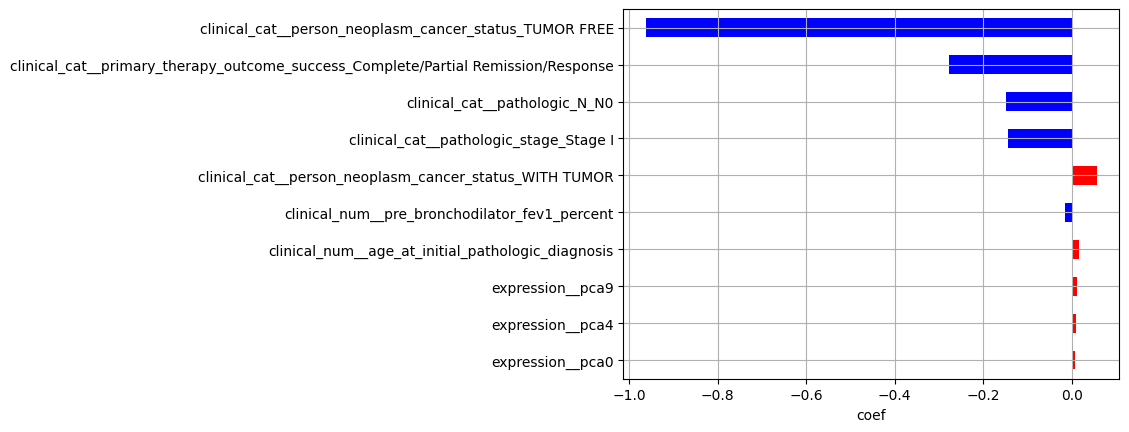

In [22]:
max_n_coefs = 10
if len(best_coefs_non_zero) > 0:
    _ = deepcopy(best_coefs_non_zero)
    if len(_) > max_n_coefs:
        _ = _[:max_n_coefs]
    _ = _[::-1]
    ax = _.plot.barh(
        legend=False, 
        color = (_ > 0).map({True: 'red', False: 'blue'}),
    )
    ax.set_xlabel("coef")
    ax.grid(True)

# cv results

In [23]:
cv_results = pd.DataFrame(cls.cv_results_)

In [24]:
# filter cv_results to get the alphas for the best values of the other params
for param in cls.best_params_:
    if param == 'coxnet__alphas':
        continue
    col = f'param_{param}'
    cv_results = cv_results.loc[cv_results[col] == cls.best_params_[param], :]

In [25]:
cv_results.loc[:, cv_results.columns.str.startswith('param_')].head(5)

,param_preprocess__expression__select__n_components,param_preprocess__clinical_num__select__k,param_preprocess__clinical_cat__select__k,param_coxnet__l1_ratio,param_coxnet__alphas
14,10,5,7,0.9,[0.18765564945147636]
50,10,5,7,0.9,[0.08812770811835315]
99,10,5,7,0.9,[0.04138693911371898]
123,10,5,7,0.9,[8.21499838021682]
455,10,5,7,0.9,[1.8117953750667568]


      alpha      mean       std
0  0.041387  0.662321  0.115785
1  0.088128  0.641595  0.100123
2  0.187656  0.583434  0.059758
3  1.811795  0.571580  0.054130
4  3.857965  0.518637  0.026357
(7, 3)


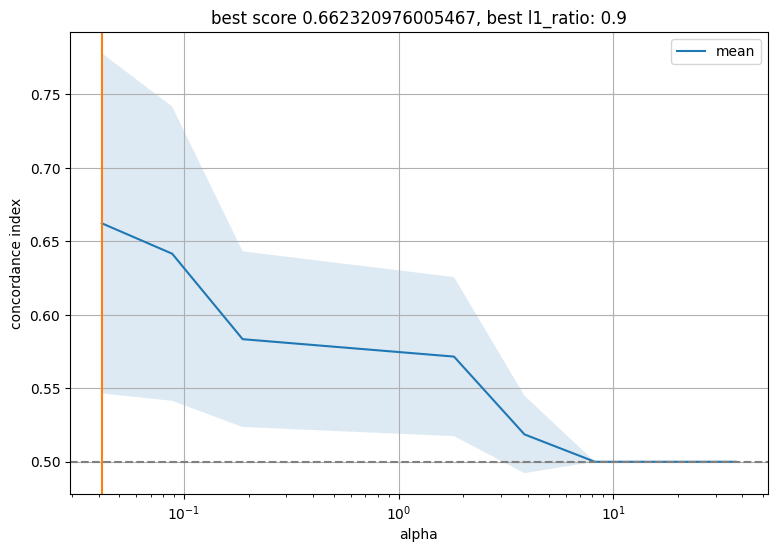

In [26]:
if cv_results.shape[0] > 1: # don't plot if there is only one alpha
    df = pd.DataFrame({
        'alpha': cv_results.param_coxnet__alphas.map(lambda x: x[0]), # 'unlist' each alpha value
        'mean': cv_results.mean_test_score,
        'std': cv_results.std_test_score,
    }).sort_values('alpha').reset_index(drop=True)
    print(df.head())
    print(df.shape)

    best_alpha = cls.best_params_["coxnet__alphas"][0]
    best_l1_ratio = cls.best_params_["coxnet__l1_ratio"]
    best_score = cls.best_score_

    ax = df.plot(x='alpha', y='mean', figsize=(9, 6))
    ax.fill_between(df['alpha'], df['mean'] - df['std'], df['mean'] + df['std'], alpha=0.15)
    ax.set_xscale("log")
    ax.set_ylabel("concordance index")
    ax.set_xlabel("alpha")
    ax.set_title(f'best score {best_score}, best l1_ratio: {best_l1_ratio}')
    ax.axvline(best_alpha, c="C1")
    ax.axhline(0.5, color="grey", linestyle="--")
    ax.grid(True)


# clinical features

In [49]:
clinical_coefs = best_coefs[best_coefs.index.str.startswith('clinical')]
clinical_coefs = clinical_coefs[clinical_coefs.abs().sort_values(ascending=False).index]
clinical_coefs.iloc[:3]

clinical_cat__person_neoplasm_cancer_status_TUMOR FREE                              -0.961547
clinical_cat__primary_therapy_outcome_success_Complete/Partial Remission/Response   -0.278188
clinical_cat__pathologic_N_N0                                                       -0.149881
dtype: float64

In [87]:
del plot_kaplan_meier

from copy import deepcopy

import matplotlib.pyplot as plt
import pandas as pd
from sksurv.nonparametric import kaplan_meier_estimator

def plot_kaplan_meier(df, feature_col, event_col='OS', time_col='OS.time'):
    _ = deepcopy(df[[event_col, time_col, feature_col]].dropna())
    if pd.api.types.is_numeric_dtype(_[feature_col]):
        if _[feature_col].nunique() > 2:
            _[feature_col] = pd.qcut(_[feature_col], 2, labels=["low", "high"], duplicates='drop')
    _ = _.sort_values(feature_col)
    classes = _[feature_col].unique()
    for cls in classes:
        mask = _[feature_col] == cls
        time, survival_prob, conf_int = kaplan_meier_estimator(
            _[event_col][mask] == 1,
            _[time_col][mask],
            conf_type="log-log",
        )
        plt.step(time, survival_prob, where="post", label=f"{feature_col} = {cls}")
        plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    plt.ylim(0, 1)
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))
    # ax.legend(loc='outside lower center', bbox_to_anchor=(1.0, 0.5))
    # return plt

In [ ]:
#import importlib
#import sys
#importlib.reload(sys.modules['lib.plotting'])

#from lib.plotting import plot_kaplan_meier

<module 'matplotlib.pyplot' from '/Users/darrenkidney/Github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

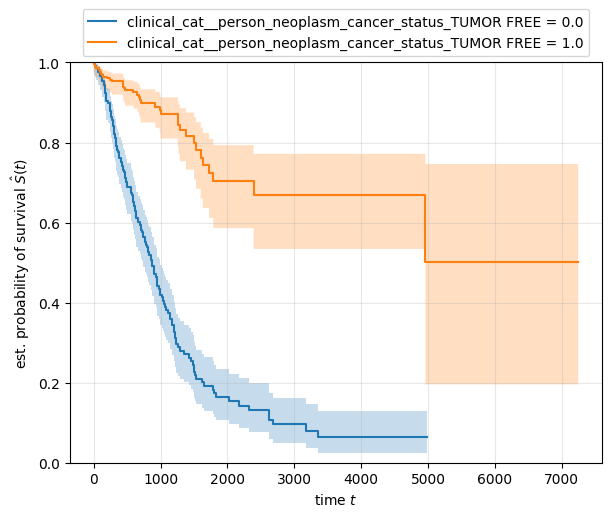

In [101]:
# top ranked clinical feature
df = pd.DataFrame(
    best_model.named_steps['preprocess'].transform(X),
    columns=best_coefs.index,
    index=X.index
)
df = survival[[event_col, time_col]]\
    .merge(df, how='inner', left_index=True, right_index=True)

plot_kaplan_meier(df, clinical_coefs.index[0])


# expression features

In [27]:
expression_coefs = best_coefs[best_coefs.index.str.startswith('expression')]
expression_coefs.iloc[:3]

expression__pca0    0.006338
expression__pca1    0.004478
expression__pca2   -0.001561
dtype: float64

In [28]:
# PCA loadings
X_pca = pd.DataFrame(
    best_model.named_steps['preprocess']['expression'].transform(X[expression_cols]),
    columns=best_model.named_steps['preprocess']['expression'].get_feature_names_out(),
    index=X.index
)
print(X_pca.iloc[:3, :3])
X_pca.shape

                      pca0       pca1       pca2
TCGA-69-7978-01 -27.164327  48.141212   9.003300
TCGA-62-8399-01 -10.612556  21.207515 -50.312061
TCGA-78-7539-01  -4.227012 -30.058295   3.148327


(506, 10)

In [29]:
expression_cols_mask = best_model.named_steps['preprocess']['expression']['varthresh'].get_support()
expression_cols_selected = expression_cols[expression_cols_mask]
print(expression_cols_selected[:3])
len(expression_cols_selected)

Index(['ARHGEF10L', 'HIF3A', 'RNF17'], dtype='object')


20192

In [30]:
# pca loadings
W = pd.DataFrame(
    best_model.named_steps['preprocess']['expression']['select'].components_,
    columns=expression_cols_selected,
    index=best_model.named_steps['preprocess']['expression'].get_feature_names_out(),
)
print(W.iloc[:3, :3])
W.shape

      ARHGEF10L     HIF3A     RNF17
pca0  -0.008438 -0.006145 -0.001270
pca1  -0.006070 -0.002351 -0.000175
pca2  -0.002305 -0.007435 -0.000876


(10, 20192)

In [31]:
# gene-level importance
gamma = pd.Series(
    W.to_numpy().T @ expression_coefs.to_numpy(),
    index=W.columns
)
print(gamma[:3])
gamma.shape

ARHGEF10L   -0.000095
HIF3A       -0.000208
RNF17       -0.000080
dtype: float64


(20192,)

In [32]:
gene_importance = gamma[gamma.abs().sort_values(ascending=False).index]
print(gene_importance[:3])
gene_importance.shape

GJB3     0.000526
KRT6B    0.000507
KRT16    0.000499
dtype: float64


(20192,)

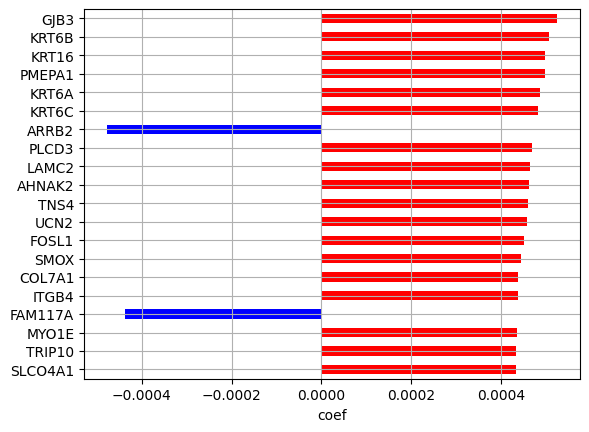

In [33]:
max_n_genes = 20
_ = deepcopy(gene_importance)
_ = _[_.abs().sort_values(ascending=False).index]
if len(_) > max_n_genes:
    _ = _[:max_n_genes]
_ = _[::-1]
ax = _.plot.barh(
    legend=False, 
    color = (_ > 0).map({True: 'red', False: 'blue'}),
)
ax.set_xlabel("coef")
ax.grid(True)

<module 'matplotlib.pyplot' from '/Users/darrenkidney/Github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

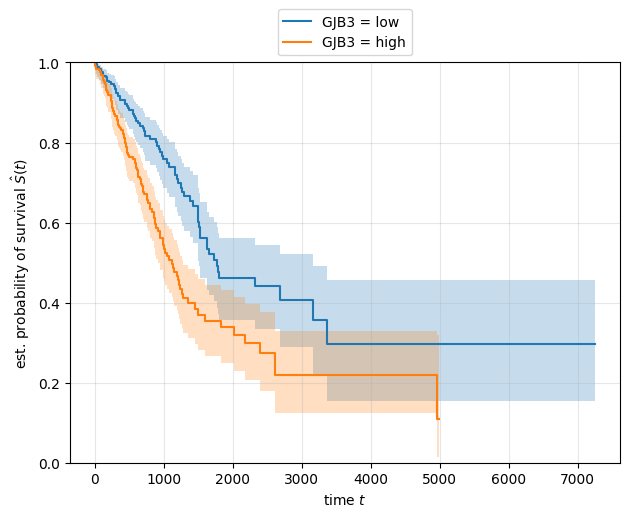

In [102]:
# top ranked gene
df = survival[[event_col, time_col]]\
    .merge(X, how='inner', left_index=True, right_index=True)
plot_kaplan_meier(df, gene_importance.index[0])